### SOM_plot_infographic.ipynb

Use to develop the SOM infographic


In [69]:
### some useful Python packages to have at hand, some will not be needed
### in this notebbook
import numpy as np
import scipy
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
#from sklearn.preprocessing import StandardScaler
# import lasagne
# import theano
import sys
sys.setrecursionlimit(1000000) # Otherwise, joblib will not save deep nets.
# imshape = (100, 9) # This is the grid shape of our images, stored here for plotting reference.
import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import mean_squared_error
#from sklearn.linear_model import Ridge
#from sklearn.decomposition import PCA
import os
os.environ["PROJ_LIB"] = "/rds/general/user/kc1116/home/anaconda3/envs/zeus/share/proj"
import matplotlib as mpl
import matplotlib
import matplotlib.colors as colors
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
import somoclu
import cartopy
import xarray
import xarray as xr
from mpl_toolkits.basemap import Basemap as bm
#import sklearn
from itertools import groupby
from scipy import stats
import cartopy.crs as ccrs
#from statsmodels.stats.multitest import (multipletests, fdrcorrection,
#                                         fdrcorrection_twostage,
#                                         NullDistribution,
#                                         local_fdr)
from scipy.stats import spearmanr, kendalltau, pearsonr #all produce identical results for binary test, use pearsonr for SOM pattern correlation

In [2]:
from functools import wraps
import errno
import os
import signal
#https://stackoverflow.com/questions/2281850/timeout-function-if-it-takes-too-long-to-finish
class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wraps(func)(wrapper)

    return decorator

In [3]:
def lag1corr(X): 
    """Compute the lag-1 autocorrelation coefficient for time series X"""
    n = len(X)
    meanx = np.mean(X)
    num = 0
    den = 0
    for i in range(n-1):
        num += (X[i+1] - meanx) * (X[i] - meanx)
    for i in range(n): 
        den += (X[i] - meanx)**2
    r = num/den # lag-1 correlation coefficient
    return r

def ESS(X): 
    """X is a time series
    Output is the equivalent sample size as suggested by Zwiers and von Storch
    """
    n = len(X)
    ## compute the sample lag-1 correlation coefficient
    r = lag1corr(X)
    n_e = n*(1-r)/(1+r)
    # n_e = n*(1-abs(r))/(1+abs(r))  # use the absolute calue of lag-1 correlation coefficient
    # estimated equivalent sample size
    if n_e <= 2: 
        eess = 2
    elif 2<n_e<=n: 
        eess = n_e
    else: 
        eess = n
    return eess

def RSS(y, yhat): 
    """y are the true values of response variable
    yhat are the predicted values of response variable
    The output is the residual sum of squares"""
    N = len(y)
    rss = 0
    for i in range(N): 
        rss += (y[i]-yhat[i])**2
    return rss

def lmtrendtest(x, y): 
    """ x is the time, y is the observation
    Output: test statistic, p-value using standard Normal, p-value using student t 
    for the slop of linear least squares regression"""
    # fit a linear regression
    m, c, r, p, err = scipy.stats.linregress(x,y) # slope, intercept, correlation, pvalue, std error
    # make a design matrix
    N = len(y)
    x0 = np.ones(N)
    X = np.column_stack((x0,x)) # design matrix with two columns, intercept & time
    # calculate the test statistic
    a = np.linalg.inv(np.matmul(X.transpose(),X))[1,1]
    ess = ESS(y) # equivalent sample size
    yhat = [c+i*m for i in x]
    rss = RSS(y, yhat) # residual sum of squares
    t = m / (np.sqrt(a*rss/(ess-2)))
    # p-value using standard normal (two tail test)
    p_value_normal = scipy.stats.norm.sf(abs(t))*2
    # p-value using student t (two tail)
    p_value_student = stats.t.sf(np.abs(t), ess-2)*2
    # lag1 autocorrelation coefficient
    rho = lag1corr(y)
    return p_value_student #rho, p, 

In [4]:
#First function takes the desired gph file, time-range, season and region and returns the prepared
#dataset for SOM_training
@timeout(5) #timeout prepData function after 5 seconds
def prepData(zg_file, yrst, yrend, season, lats_arr, lons_arr, g, zg_str, grid_res, lat_str, lon_str):
    """
    Select the season and region from the data
    """
    #print("prepData")
    yrst, yrend = zg_file['time.year'].min(), zg_file['time.year'].max()
    year_arr = np.arange(yrst,yrend+1)
    lats = np.arange(lats_arr[0],lats_arr[1],grid_res) #good for 1x1 data
    lons = np.arange(lons_arr[0],lons_arr[1],grid_res)  #good for 1x1 data
    #print(f"lats, lons = {lats, lons}")    
    if lat_str == "latitude":
        data_europe_yr = zg_file.sel(latitude = np.isin(zg_file['latitude'], lats), 
                                      longitude = np.isin(zg_file['longitude'], lons),
                                      time = np.isin(zg_file['time.year'], year_arr),
                                    ).sel(time = np.isin(zg_file['time.season'], season))
    else:
        data_europe_yr = zg_file.sel(lat = np.isin(zg_file['lat'], lats), 
                                      lon = np.isin(zg_file['lon'], lons),
                                      time = np.isin(zg_file['time.year'], year_arr),
                                    ).sel(time = np.isin(zg_file['time.season'], season))        
    #print(f"data_europe_yr = {data_europe_yr}")    
    dates = data_europe_yr['time']
    nt_yr, nr_lat, nr_lon = zg_file[zg_str].shape
    #print(f"data_europe_yr[zg_str].shape = {data_europe_yr[zg_str].shape}")  
    
    #data_yr_reshaped = data_europe_yr[zg_str].values.reshape(nt_yr, nr_lat*nr_lon)/g#*1e6#/g #reshaped for the SOM
    #print(f"data_yr_reshaped = {data_yr_reshaped}")     
    m = bm(projection='cyl',llcrnrlat=lats_arr[0],urcrnrlat=lats_arr[1]-1,llcrnrlon=lons_arr[0],urcrnrlon=lons_arr[1]-1,resolution='l') # may need to subtract 180 from the lon coords  
    return lats, lons, dates, nt_yr, nr_lat, nr_lon, m

In [5]:
#Function to plot the SOM trends
#added values to modify Gerald's function (issues with date formatting)
def plotSOMTrends(som_yr, dates, n_rows, n_columns, savefig_trends, colormap_str, mult_test_method, train_input=False, bmus=None, JJA_days=92, yrst=1979, yrend=2019, samp=50):
    """
    Plots the trends (occurrence, persistence, max duration) of the SOM patterns generated from the GPH data. 
    
    Parameters
    ----------
    som_yr    : somoclu.train.Somoclu
        The trained SOM (somoclu object)
    seas_yr   : xarray.DataArray
        Data array containing GPH data and information on time, latitude, longitude variables in the selected time range, season and region
        
    Returns
    ---------
    grad_list : list 
        List of the gradients of the pattern occurrence trends computed by linear least-squares regression 
    all_occur : list 
        List of occurrences per day in the trained dataset for each SOM pattern
    """
    if train_input==False:
        #calculate the best matching unit
        #Extract pattern data (occurence, persistence, max duration)
        #Store each pattern data as a binary list of len(dates), i.e. [1,0,0,0,1...,1]
        bmus = som_yr.bmus
    
    
    global all_occur #Extra code to store the occurences in a global variable that I can access later

    all_occur = [[] for i in range(max(n_rows,n_columns))]
    for a in range(n_rows):
        for b in range(n_columns): 
            curr_occur = []
            for c in bmus:
                if train_input==False:
                    if c.tolist() == [b,a]: #### need to swap the indices here!! #b'a
                        curr_occur.append(1) #This pattern occured on this date
                    else:
                        curr_occur.append(0) #This pattern didn't occur 
                else:
                    if c == [b,a]: #### need to swap the indices here!! #b'a
                        curr_occur.append(1) #This pattern occured on this date
                    else:
                        curr_occur.append(0) #This pattern didn't occur                     
            all_occur[a].append(curr_occur)

    if n_columns == 1:
        f, axes1 = plt.subplots(nrows=n_rows, ncols=n_columns+1, figsize=(10,10))
    if n_rows == 1:
        f, axes1 = plt.subplots(nrows=n_rows+1, ncols=n_columns, figsize=(10,10))
    #Plotting axes the extracted circulation data 
    f, axes1 = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,10))
    f.subplots_adjust(hspace=0.2, wspace=0.2)


    #Now sort according to relevant dates
    #dates = seas_yrs['time'].data[:]
    #dates = pd.date_range(start='1/1/1979', end=f'31/12/{x}')

    #Loop through each set of circulation occurence data 
    

    test_num = 8 #number of p value tests in family of hypotheses (occ, persis, max_dur and event_no * 2)
    #pvalue and gradient matrices for each node
    pval_mat, grad_mat = np.zeros((n_rows,n_columns,test_num)), np.zeros((n_rows,n_columns,test_num))
    #Store trend values
    grad_list_occ, grad_list_persis, grad_list_maxdur, grad_list_evno  = [], [], [], []
    pvals_list_occ, pvals_list_persis, pvals_list_maxdur, pvals_list_evno = [], [], [], []
    years_zeros = np.zeros((34*92))
    for row in range(n_rows):  
        for col in range(n_columns):
            #Need some exception handling for rare cases where any of the patterns doesnt occur in a year
            #NOTE the swapped indices [col][row] here! Doulbe check with Joy's code, see if node number can be confirmed
            #print(f"all_occur[row][col] = {all_occur[row][col]}")
            #print(f"dates = {dates}")
            #all_occur[row][col] is the relevant matrix for investigating caase studies
            #print(f"all_occur = {all_occur}")
            cum_data = pd.Series(np.array(all_occur[row][col]), index=dates.values)
            #print(f"cum_data = {cum_data}")
            #to generate the years in the dataset, since cum_data.index.year has issues
            years_num = yrend - yrst
            JJA_days = 92       
            #print(f"cum_data.shape = {cum_data.shape}")
            years_num = int(cum_data.shape[0]/JJA_days)
            #print(f"years_num = {years_num}")
            years_zeros = np.zeros((years_num*JJA_days))
            #print(f"years_num = {years_num}")
            if type(yrst) == int:
                arr_gen = np.array([years_zeros[JJA_days*i:JJA_days*(i+1)]+i+yrst for i in range(years_num)
                               ]).reshape(years_num*JJA_days)
            else:
                arr_gen = np.array([years_zeros[JJA_days*i:JJA_days*(i+1)]+i+int(yrst.values) for i in range(years_num)
                               ]).reshape(years_num*JJA_days)

            sort_to_year = cum_data.groupby(arr_gen).apply(list)
            year = sort_to_year.keys().tolist() #[1979, 1980,...]
            occ = [sum(d) for d in sort_to_year]  #[25,40,...]
            # Count streaks 
            streaks = [[sum(1 for i in g) for k,g in groupby(x) if k == 1] for x in sort_to_year]
            streak_count = [[(k, sum(1 for i in g)) for k,g in groupby(sorted(x)) ] for x in streaks]
            
            #Persistence (if statement to avoid division by zero )
            persis = [ sum([x[0]*x[1] for x in year])/sum([x[1] for x in year]) if sum([x[1] for x in year]) != 0 else 0 for year in streak_count ]
            #Max Duration 
            max_dur = [ year[-1][0] if year != [] else 0 for year in streak_count]
            

            def len_iter(items):
                return sum(1 for _ in items)            
            
            def consecutive_one_len(data):
                return len(list(len_iter(run) for val, run in groupby(data) if val))            
            event_no = [consecutive_one_len(d) for d in sort_to_year]      
            #event_no = [sum(d) for d in sort_to_year]        
            #np.ones((len(sort_to_year)))*sum(sort_to_year)
            #Fitting via Linear Least Squares Regression (With Serial Correlation)
            def fit(m,x,c):  #Simple linear function
                return m*x + c

            #Occurrence 
            m0, c0, r0, p0, err0 = scipy.stats.linregress(year,occ)
            m1, c1, r1, p1, err1 = scipy.stats.linregress(year[samp:],occ[samp:])
            fit_occ = [fit(m0,x,c0) for x in year]
            fit_occ1 = [fit(m1,x,c1) for x in year[samp:]]
            grad_list_occ.append(m0)

            #Persistence
            m2, c2, r2, p2, err2 = scipy.stats.linregress(year,persis)
            m3, c3, r3, p3, err3 = scipy.stats.linregress(year[samp:],persis[samp:])
            fit_per = [fit(m2,x,c2) for x in year]
            fit_per1 = [fit(m3,x,c3) for x in year[samp:]]
            grad_list_persis.append(m2)
#             pvals_list_occ.append(p0)            
#             pvals_list_persis.append(p2)     
#             pvals_list_maxdur.append(p4)     
#             pvals_list_evno.append(p6)            
            #Max duration
            m4, c4, r4, p4, err4 = scipy.stats.linregress(year,max_dur)
            m5, c5, r5, p5, err5 = scipy.stats.linregress(year[samp:],max_dur[samp:])
            fit_dur = [fit(m4,x,c4) for x in year]
            fit_dur1 = [fit(m5,x,c5) for x in year[samp:]]
            grad_list_maxdur.append(m4)
          
            #Event number
            m6, c6, r6, p6, err6 = scipy.stats.linregress(year,event_no)
            m7, c7, r7, p7, err7 = scipy.stats.linregress(year[samp:],event_no[samp:])
            fit_evno = [fit(m6,x,c6) for x in year]
            fit_evno1 = [fit(m7,x,c7) for x in year[samp:]]   
            grad_list_evno.append(m6)


            
            def pval_str(gradval, pval, pval_thresh = 0.05):
                """
                Calculate the corrected p value and create the string which is bold if the p value is below the threshold
                """
                if pval < pval_thresh:
                    return str(r"$\bf{" + str(round(gradval,3)) + "("+ str(round(pval,2)) +")" + "}$")
                else:    
                    return str(str(round(gradval,3)) + "("+ str(round(pval,2)) +")")
               

            #Plot results
            #if col == 1 or row == 1:
            try:
                axes1[row][col].scatter(year, occ, c='k', s=3, label="Occurrences") #plot occurrences vs years
                axes1[row][col].plot(year, fit_occ, c='k')
                axes1[row][col].plot(year[samp:], fit_occ1, '--', c='k')

                axes1[row][col].scatter(year, persis, c='b', s=3, label="Persistence") #plot persistence vs years
                axes1[row][col].plot(year, fit_per, c='b')
                axes1[row][col].plot(year[samp:], fit_per1, '--', c='b')

                axes1[row][col].scatter(year, max_dur, c='r', s=3, label="Max Duration") #plot max duration vs years
                axes1[row][col].plot(year, fit_dur, c='r')
                axes1[row][col].plot(year[samp:], fit_dur1, '--', c='r')

                axes1[row][col].scatter(year, event_no, c=(0.5,0.5,0.5), s=3, label="Event no") #plot event number vs years
                axes1[row][col].plot(year, fit_evno, c=(0.5,0.5,0.5))
                axes1[row][col].plot(year[samp:], fit_evno1, '--', c=(0.5,0.5,0.5))           
            except:
                axes1[row].scatter(year, occ, c='k', s=3, label="Occurrences") #plot occurrences vs years
                axes1[row].plot(year, fit_occ, c='k')
                axes1[row].plot(year[samp:], fit_occ1, '--', c='k')

                axes1[row].scatter(year, persis, c='b', s=3, label="Persistence") #plot persistence vs years
                axes1[row].plot(year, fit_per, c='b')
                axes1[row].plot(year[samp:], fit_per1, '--', c='b')

                axes1[row].scatter(year, max_dur, c='r', s=3, label="Max Duration") #plot max duration vs years
                axes1[row].plot(year, fit_dur, c='r')
                axes1[row].plot(year[samp:], fit_dur1, '--', c='r')

                axes1[row].scatter(year, event_no, c=(0.5,0.5,0.5), s=3, label="Event no") #plot event number vs years
                axes1[row].plot(year, fit_evno, c=(0.5,0.5,0.5))
                axes1[row].plot(year[samp:], fit_evno1, '--', c=(0.5,0.5,0.5))                    
            
            if n_rows*n_columns > 5:
                font_size_text = 8
                font_size_title = 9 
            else:
                font_size_text = 11
                font_size_title = 12                  
            font_size_suptitle = 14
            #corrected p values
            (pval_occ, pval_occ_samp, pval_persis, pval_persis_samp, 
             pval_max_dur, pval_max_dur_samp, pval_event_no, pval_event_no_samp) = (lmtrendtest(year, occ), lmtrendtest(year[samp:], occ[samp:]),
                                                                                    lmtrendtest(year, persis), lmtrendtest(year[samp:], persis[samp:]),
                                                                                    lmtrendtest(year, max_dur), lmtrendtest(year[samp:], max_dur[samp:]),
                                                                                    lmtrendtest(year, event_no), lmtrendtest(year[samp:], event_no[samp:]))
            
            #store the calculated p values in a matrix
            pval_mat[row,col,:] = [pval_occ, pval_occ_samp, pval_persis, pval_persis_samp, pval_max_dur, pval_max_dur_samp, pval_event_no, pval_event_no_samp]
            grad_mat[row,col,:] = [m0,m1,m2,m3,m4,m5,m6,m7]

            
            
            
            #pval_persis, pval_max_dur, pval_event_no = lmtrendtest(year, occ), lmtrendtest(year, persis), lmtrendtest(year, max_dur), lmtrendtest(year, event_no)
            
            #m0_str, m1_str, m2_str, m3_str, m4_str, m5_str, m6_str, m7_str = (pval_str(m0, p0, year, occ), pval_str(m1, p1, year[samp:], occ[samp:]), 
            #                                                  pval_str(m2, p2, year, persis), pval_str(m3, p3, year[samp:], persis[samp:]), 
            #                                                  pval_str(m4, p4, year, max_dur), pval_str(m5, p5, year[samp:], max_dur[samp:]),
            #                                                  pval_str(m6, p6, year, event_no), pval_str(m7, p7, year[samp:], event_no[samp:]))            
            
            #instead of plotting the p values directly, store the p values with their corresponding error
            #this enables a statistical test to be run on the total set of pvalues (FDR, Holm–Bonferroni method for FWER and k-wise FWER)
    #for row in range(n_rows):  
    #    for col in range(n_columns):  
            #print(f"pval_mat[row,col,:] = {pval_mat[row,col,:]}")
        
    def Bonferroni_kFWER(pvals, k = 5):
        """
        Apply the Bonferroni correction to the pvalues
        From Horton et al. (2015):
        "One option for the value of k is to use the expected number of
        hypotheses that will be rejected at a given significance level. 
        For instance, in our study, out of 112 total ‘local’ hypotheses,
        5 or 6 hypotheses will be significant at the 5% significance 
        level by chance (112 3 0.05 5 5.6). In this case, one can evaluate
        the probability that 7 or more hypotheses are falsely rejected,
        since on average about 6 could be rejected as significant by chance.
        Using this logic, for 9 nodes, 8 tests and alpha = 0.05 use k = 5 (1+9*8*0.05 rounded up)
        """
        #pvals_corr = len(pvals)*pval/k
        pvals_corr = [len(pvals)*p/k if len(pvals)*p/k < 1 else 1 for p in pvals]
        return np.array(pvals_corr)
    if mult_test_method == "none":
        print("No multiple hypothesis correction applied")
    elif mult_test_method == "k-FWER":    
        #test for the k-familywise error rate using the Bonferroni correction
        pval_arr = Bonferroni_kFWER(pval_mat[:,:,:].flatten(), k = 20)
        pval_mat = pval_arr.reshape((n_rows,n_columns,test_num)) 
    else:
        pval_arr = multipletests(pval_mat[:,:,:].flatten(), alpha=0.05, method=mult_test_method, is_sorted=False, returnsorted=False)[1]  
        pval_mat = pval_arr.reshape((n_rows,n_columns,test_num)) 
           
    for row in range(n_rows):  
        for col in range(n_columns):            
            
            m0,m1,m2,m3,m4,m5,m6,m7 = grad_mat[row,col,:]
            p0,p1,p2,p3,p4,p5,p6,p7 = pval_mat[row,col,:]    
            pvals_list_occ.append(p0)            
            pvals_list_persis.append(p2)     
            pvals_list_maxdur.append(p4)     
            pvals_list_evno.append(p6)               
            
            #Legend
            #calculate the corrected p values and create the strings to reduce the bold text
            m0_str, m1_str, m2_str, m3_str, m4_str, m5_str, m6_str, m7_str = (pval_str(m0, p0), pval_str(m1, p1), 
                                                              pval_str(m2, p2), pval_str(m3, p3), 
                                                              pval_str(m4, p4), pval_str(m5, p5),
                                                              pval_str(m6, p6), pval_str(m7, p7))
            try:
                axes1[row][col].text(0.16, 0.99, "Occurrence", transform=axes1[row][col].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center')
                axes1[row][col].text(0.16, 0.93, m0_str,
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center')
                axes1[row][col].text(0.16, 0.87, m1_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center')

                axes1[row][col].text(0.49, 0.99, "Persistence", transform=axes1[row][col].transAxes, fontsize=font_size_title, verticalalignment='top',horizontalalignment='center', color='b')
                axes1[row][col].text(0.49, 0.93, m2_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='b')
                axes1[row][col].text(0.49, 0.87, m3_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='b')

                axes1[row][col].text(0.83, 0.99, "Max duration", transform=axes1[row][col].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center', color='r')
                axes1[row][col].text(0.83, 0.93, m4_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='r')
                axes1[row][col].text(0.83, 0.87, m5_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='r')      

                axes1[row][col].text(0.16, 0.82, f"Event no", transform=axes1[row][col].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))
                axes1[row][col].text(0.16, 0.76, m6_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))
                axes1[row][col].text(0.16, 0.70, m7_str, 
                                     transform=axes1[row][col].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))               

                axes1[row][col].set_ylim((0,55))
            except:
                axes1[row].text(0.16, 0.99, "Occurrence", transform=axes1[row].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center')
                axes1[row].text(0.16, 0.93, m0_str,
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center')
                axes1[row].text(0.16, 0.87, m1_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center')

                axes1[row].text(0.49, 0.99, "Persistence", transform=axes1[row].transAxes, fontsize=font_size_title, verticalalignment='top',horizontalalignment='center', color='b')
                axes1[row].text(0.49, 0.93, m2_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='b')
                axes1[row].text(0.49, 0.87, m3_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='b')

                axes1[row].text(0.83, 0.99, "Max duration", transform=axes1[row].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center', color='r')
                axes1[row].text(0.83, 0.93, m4_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='r')
                axes1[row].text(0.83, 0.87, m5_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color='r')      
                
                axes1[row].text(0.16, 0.82, "Event no", transform=axes1[row].transAxes, fontsize=font_size_title, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))
                axes1[row].text(0.16, 0.76, m6_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))
                axes1[row].text(0.16, 0.70, m7_str, 
                                     transform=axes1[row].transAxes, fontsize=font_size_text, verticalalignment='top', horizontalalignment='center', color=(0.5,0.5,0.5))               

                axes1[row].set_ylim((0,55))                
        f.suptitle('Time series of circulation trends', fontsize=14)
    
    f.savefig(savefig_trends, bbox_inches="tight", dpi=300)
    grad_list_arr = [grad_list_occ, grad_list_persis, grad_list_maxdur, grad_list_evno]
    pvals_list_arr = [pvals_list_occ, pvals_list_persis, pvals_list_maxdur, pvals_list_evno]
    return grad_list_arr, pvals_list_arr, all_occur


In [6]:

#codebook_da = xarray.DataArray(som_yr_era5_EUR.codebook, name = "codebook", dims = ("row", "col", "latlon") )
    
#bmu_arr = Identify_BMU_from_codebook(codebook_da, data_yr_reshaped)  

def Identify_BMU_from_codebook(codebook_da, data_yr_reshaped):
    """
    When calculating the best matching unit from a given codebook (use the codebook from reanalysis)
    need to calculate the best matching units array
    output an array specifying the BMU with [rownum, colnum] for each day in the dataset
    
    codebook_da - codebook as a DataArray
    data_yr_reshaped - data from the xarray, reshaped so that the lat/lon values are along one axis
    """
    codebook_da_reshaped = codebook_da.values.reshape(9,600)
    rownum, colnum = 3,3
    bmu_arr=[]
    for i, data_day in enumerate(data_yr_reshaped):
        #if i < 20:
            min_euclidean_distance = 1e12
            #print(data_day.shape)
            for rowcolnum, codebook in enumerate(codebook_da_reshaped):
                #calculate Euclidean distance between codebook and day in dataset
                euclidean_distance = sum((codebook-data_day)**2)
                if euclidean_distance < min_euclidean_distance:
                    min_euclidean_distance = euclidean_distance
                    min_rowcolnum = rowcolnum
            bmu_arr.append([min_rowcolnum//rownum, min_rowcolnum%colnum])
    
    return bmu_arr
    
    
#bmu_arr = Identify_BMU_from_codebook(codebook_da, data_yr_reshaped)    

In [7]:
#Function to plot the SOM trends
#added values to modify Gerald's function (issues with date formatting)
def plotSOMTrends_noplot(som_yr, dates, n_rows, n_columns, savefig_trends, colormap_str, mult_test_method, JJA_days=92, yrst=1979, yrend=2019, samp=50):
    """
    Plots the trends (occurrence, persistence, max duration) of the SOM patterns generated from the GPH data. 
    
    Parameters
    ----------
    som_yr    : somoclu.train.Somoclu
        The trained SOM (somoclu object)
    seas_yr   : xarray.DataArray
        Data array containing GPH data and information on time, latitude, longitude variables in the selected time range, season and region
        
    Returns
    ---------
    grad_list : list 
        List of the gradients of the pattern occurrence trends computed by linear least-squares regression 
    all_occur : list 
        List of occurrences per day in the trained dataset for each SOM pattern
    """
    
    #Extract pattern data (occurence, persistence, max duration)
    #Store each pattern data as a binary list of len(dates), i.e. [1,0,0,0,1...,1]
    bmus = som_yr.bmus
    global all_occur #Extra code to store the occurences in a global variable that I can access later

    all_occur = [[] for i in range(max(n_rows,n_columns))]
    for a in range(n_rows):
        for b in range(n_columns): 
            curr_occur = []
            for c in bmus:
                if c.tolist() == [b,a]: #### need to swap the indices here!! #b'a
                    curr_occur.append(1) #This pattern occured on this date
                else:
                    curr_occur.append(0) #This pattern didn't occur 
            all_occur[a].append(curr_occur)
    #Now sort according to relevant dates
    #dates = seas_yrs['time'].data[:]
    #dates = pd.date_range(start='1/1/1979', end=f'31/12/{x}')

    #Loop through each set of circulation occurence data 
    

    test_num = 8 #number of p value tests in family of hypotheses (occ, persis, max_dur and event_no * 2)
    #pvalue and gradient matrices for each node
    pval_mat, grad_mat = np.zeros((n_rows,n_columns,test_num)), np.zeros((n_rows,n_columns,test_num))
    #Store trend values
    grad_list_occ, grad_list_persis, grad_list_maxdur, grad_list_evno  = [], [], [], []
    pvals_list_occ, pvals_list_persis, pvals_list_maxdur, pvals_list_evno = [], [], [], []
    years_zeros = np.zeros((34*92))
    for row in range(n_rows):  
        for col in range(n_columns):
            #Need some exception handling for rare cases where any of the patterns doesnt occur in a year
            #NOTE the swapped indices [col][row] here! Doulbe check with Joy's code, see if node number can be confirmed
            #print(f"all_occur[row][col] = {all_occur[row][col]}")
            #print(f"dates = {dates}")
            #all_occur[row][col] is the relevant matrix for investigating caase studies
            
            cum_data = pd.Series(np.array(all_occur[row][col]), index=dates.values)
            #to generate the years in the dataset, since cum_data.index.year has issues
            years_num = yrend - yrst
            JJA_days = 92            
            years_num = int(cum_data.shape[0]/JJA_days)
            years_zeros = np.zeros((years_num*JJA_days))
            arr_gen = np.array([years_zeros[JJA_days*i:JJA_days*(i+1)]+i+yrst for i in range(years_num)
                               ]).reshape(years_num*JJA_days)

            sort_to_year = cum_data.groupby(arr_gen).apply(list)
            year = sort_to_year.keys().tolist() #[1979, 1980,...]
            occ = [sum(d) for d in sort_to_year]  #[25,40,...]
            # Count streaks 
            streaks = [[sum(1 for i in g) for k,g in groupby(x) if k == 1] for x in sort_to_year]
            streak_count = [[(k, sum(1 for i in g)) for k,g in groupby(sorted(x)) ] for x in streaks]
            
            #Persistence (if statement to avoid division by zero )
            persis = [ sum([x[0]*x[1] for x in year])/sum([x[1] for x in year]) if sum([x[1] for x in year]) != 0 else 0 for year in streak_count ]
            #Max Duration 
            max_dur = [ year[-1][0] if year != [] else 0 for year in streak_count]
            

            def len_iter(items):
                return sum(1 for _ in items)            
            
            def consecutive_one_len(data):
                return len(list(len_iter(run) for val, run in groupby(data) if val))            
            event_no = [consecutive_one_len(d) for d in sort_to_year]      
            #event_no = [sum(d) for d in sort_to_year]        
            #np.ones((len(sort_to_year)))*sum(sort_to_year)
            #Fitting via Linear Least Squares Regression (With Serial Correlation)
            def fit(m,x,c):  #Simple linear function
                return m*x + c

            #Occurrence 
            m0, c0, r0, p0, err0 = scipy.stats.linregress(year,occ)
            m1, c1, r1, p1, err1 = scipy.stats.linregress(year[samp:],occ[samp:])
            fit_occ = [fit(m0,x,c0) for x in year]
            fit_occ1 = [fit(m1,x,c1) for x in year[samp:]]
            grad_list_occ.append(m0)

            #Persistence
            m2, c2, r2, p2, err2 = scipy.stats.linregress(year,persis)
            m3, c3, r3, p3, err3 = scipy.stats.linregress(year[samp:],persis[samp:])
            fit_per = [fit(m2,x,c2) for x in year]
            fit_per1 = [fit(m3,x,c3) for x in year[samp:]]
            grad_list_persis.append(m2)       
            #Max duration
            m4, c4, r4, p4, err4 = scipy.stats.linregress(year,max_dur)
            m5, c5, r5, p5, err5 = scipy.stats.linregress(year[samp:],max_dur[samp:])
            fit_dur = [fit(m4,x,c4) for x in year]
            fit_dur1 = [fit(m5,x,c5) for x in year[samp:]]
            grad_list_maxdur.append(m4)
          
            #Event number
            m6, c6, r6, p6, err6 = scipy.stats.linregress(year,event_no)
            m7, c7, r7, p7, err7 = scipy.stats.linregress(year[samp:],event_no[samp:])
            fit_evno = [fit(m6,x,c6) for x in year]
            fit_evno1 = [fit(m7,x,c7) for x in year[samp:]]   
            grad_list_evno.append(m6)
            #corrected p values
            (pval_occ, pval_occ_samp, pval_persis, pval_persis_samp, 
             pval_max_dur, pval_max_dur_samp, pval_event_no, pval_event_no_samp) = (lmtrendtest(year, occ), lmtrendtest(year[samp:], occ[samp:]),
                                                                                    lmtrendtest(year, persis), lmtrendtest(year[samp:], persis[samp:]),
                                                                                    lmtrendtest(year, max_dur), lmtrendtest(year[samp:], max_dur[samp:]),
                                                                                    lmtrendtest(year, event_no), lmtrendtest(year[samp:], event_no[samp:]))
            
            #store the calculated p values in a matrix
            pval_mat[row,col,:] = [pval_occ, pval_occ_samp, pval_persis, pval_persis_samp, pval_max_dur, pval_max_dur_samp, pval_event_no, pval_event_no_samp]
            grad_mat[row,col,:] = [m0,m1,m2,m3,m4,m5,m6,m7]
        
    def Bonferroni_kFWER(pvals, k = 5):
        """
        Apply the Bonferroni correction to the pvalues
        From Horton et al. (2015):
        "One option for the value of k is to use the expected number of
        hypotheses that will be rejected at a given significance level. 
        For instance, in our study, out of 112 total ‘local’ hypotheses,
        5 or 6 hypotheses will be significant at the 5% significance 
        level by chance (112 3 0.05 5 5.6). In this case, one can evaluate
        the probability that 7 or more hypotheses are falsely rejected,
        since on average about 6 could be rejected as significant by chance.
        Using this logic, for 9 nodes, 8 tests and alpha = 0.05 use k = 5 (1+9*8*0.05 rounded up)
        """
        #pvals_corr = len(pvals)*pval/k
        pvals_corr = [len(pvals)*p/k if len(pvals)*p/k < 1 else 1 for p in pvals]
        return np.array(pvals_corr)
    if mult_test_method == "none":
        print("No multiple hypothesis correction applied")
    elif mult_test_method == "k-FWER":    
        #test for the k-familywise error rate using the Bonferroni correction
        pval_arr = Bonferroni_kFWER(pval_mat[:,:,:].flatten(), k = 20)
        pval_mat = pval_arr.reshape((n_rows,n_columns,test_num)) 
    else:
        pval_arr = multipletests(pval_mat[:,:,:].flatten(), alpha=0.05, method=mult_test_method, is_sorted=False, returnsorted=False)[1]  
        pval_mat = pval_arr.reshape((n_rows,n_columns,test_num)) 
           
    for row in range(n_rows):  
        for col in range(n_columns):            
            
            m0,m1,m2,m3,m4,m5,m6,m7 = grad_mat[row,col,:]
            p0,p1,p2,p3,p4,p5,p6,p7 = pval_mat[row,col,:]    
            pvals_list_occ.append(p0)            
            pvals_list_persis.append(p2)     
            pvals_list_maxdur.append(p4)     
            pvals_list_evno.append(p6)
    grad_list_arr = [grad_list_occ, grad_list_persis, grad_list_maxdur, grad_list_evno]
    pvals_list_arr = [pvals_list_occ, pvals_list_persis, pvals_list_maxdur, pvals_list_evno]
    return grad_list_arr, pvals_list_arr, all_occur


In [8]:
@timeout(20) #timeout function after 20 seconds
def get_SOM_data_noplot(zg_file, yrst, yrend, season, region, init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling,
            savefig_title, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g, zg_str, colormap_str, suptitle, mult_test_method, #
                data_yr_reshaped, grid_res, vmin, vmax, step, lat_str, lon_str, train_input = False, som_yr = None, JJA_days=92,):
    """
    Prepares the GPH anomaly dataset for SOM training from the NCEP2-DOE reanalysis data by selecting data within 
    the desired time range, season and region
    
    Parameters
    ----------
    yrst         : int
        Starting/first year of the dataset to pick from
    yrend        : int
        Ending/ last year of the dataset to pick from
    season       : str
        Seasons of the year, {"MAM", "JJA", "SON", "DJF"}
    region       : str
        Region to pick the data from, {"Europe", "WA", "CA", "EA", "ENA"} 
    init         : str
        SOM nitialisation scheme, "random" or "pca"
    neigh        : str
        SOM neighbourhood function, "gaussian" or "bubble"
    std          : float
        Parameter to set the coefficient in the Gaussian neighborhood function, somoclu default 0.5
    ep           : int
        The number of epochs to train the map for
    rad_0        : float
        The initial radius on the map where the update happens around a best matching unit, somoclu default 0 will trigger a value of min(n_columns, n_rows)/2
    rad_N        : float
        The radius on the map where the update happens around a best matching unit in the final epoch, somoclu default 1
    rad_cooling  : str
        The cooling strategy between radius0 and radiusN, "linear" or "exponential"
    scale_0      : float
        The initial learning scale, somoclu default 0.1
    scale_N      : float
        The learning scale in the final epoch, somoclu default 0.01
    scale_cooling: str
        Number of edges to attach from a new node to existing nodes
    
    Returns
    ---------
    freq_list : list
        List of the occurence frequencies of each SOM pattern
    grad_list : list
        List of the gradients of the pattern occurrence trends computed by linear least-squares regression
    all_occur : list 
        List of occurrences per day in the trained dataset for each SOM pattern
    """
    #Get the prepared data
    #issue with prepData function so load information beforehand
    lats, lons, dates, nt_yr, nr_lat, nr_lon, m = prepData(zg_file, yrst, yrend, "JJA", lats_arr, lons_arr, g, zg_str, grid_res, lat_str, lon_str)
    #lats, lons, dates = zg_file[lat_str], zg_file[lon_str], zg_file['time']
    #Train the SOM if not inputting an already trained SOM pattern
    if train_input == False:
        som_yr = somoclu.Somoclu(n_columns, n_rows, maptype="planar",compactsupport=True,initialization=f"{init}", neighborhood=f"{neigh}", std_coeff=std)
        som_yr.train(data_yr_reshaped,epochs=ep,radius0=rad_0,radiusN=rad_N,radiuscooling=f"{rad_cooling}",
                 scale0=scale_0,scaleN=scale_N,scalecooling=f"{scale_cooling}")
    print(f"data_yr_reshaped.shape = {data_yr_reshaped.shape}")

    #Plot the trained SOM nodes 
    g, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,5))
    g.subplots_adjust(hspace=0.2, wspace=0.2)
    #Store the frequency data in a list
    freq_list = []
    for i in range(n_rows): 
        for j in range(n_columns):
            try:
                ax = axes[i][j]
                node = som_yr.codebook[i][j]
            except: #doesn't work when not indexed, when one of n_rows or n_columns = 1
                if n_rows > n_columns:
                    ax = axes[i]
                    node = som_yr.codebook[j]
                else:
                    ax = axes[i]
                    node = som_yr.codebook[i]
            node_orig = node.reshape(nr_lat,nr_lon)            
            
            im = plot_field(m, node_orig, lats, lons, vmin, vmax, step, ncols = n_columns, nrows = n_rows,  #for pv use -330/250, 330/250, 30/250 as levels
                       ax=ax, grid=False, cmap=plt.get_cmap(colormap_str), fig=g, row=i, col=j)
            #Pattern frequencies
            freq = sum([1 for pat in som_yr.bmus if pat.tolist() == [j,i]])/float(len(som_yr.bmus))*100 #note the flipped indices
            freq_list.append(freq)
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(0.05, 0.95, str(round(freq,1))+"%", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            #ax1.ticklabel_format(style="plain")            
    g.suptitle(f"{suptitle}", fontsize=14)    
    ax.ticklabel_format(style="plain")    
    #g.colorbar(im, orientation="horizontal")
    grad_list_arr, pvals_list_arr, all_occur = plotSOMTrends(som_yr, dates, n_rows, n_columns, savefig_trends, colormap_str, mult_test_method,
                                                             JJA_days=JJA_days, yrst=yrst, yrend=yrend, samp=samp)
    g.savefig(savefig_title, bbox_inches="tight", dpi=300)
    return freq_list, grad_list_arr, pvals_list_arr, all_occur, som_yr

In [10]:
@timeout(20) #timeout function after 20 seconds
def get_SOM_data(zg_file, yrst, yrend, season, region, init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling,
            savefig_title, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g, zg_str, colormap_str, suptitle, mult_test_method, #yrst=1979, yrend=2013
                data_yr_reshaped, grid_res, vmin, vmax, step, lat_str, lon_str, train_input = False, som_yr = None, JJA_days=92):
    """
    Prepares the GPH anomaly dataset for SOM training from the NCEP2-DOE reanalysis data by selecting data within 
    the desired time range, season and region
    
    Parameters
    ----------
    yrst         : int
        Starting/first year of the dataset to pick from
    yrend        : int
        Ending/ last year of the dataset to pick from
    season       : str
        Seasons of the year, {"MAM", "JJA", "SON", "DJF"}
    region       : str
        Region to pick the data from, {"Europe", "WA", "CA", "EA", "ENA"} 
    init         : str
        SOM nitialisation scheme, "random" or "pca"
    neigh        : str
        SOM neighbourhood function, "gaussian" or "bubble"
    std          : float
        Parameter to set the coefficient in the Gaussian neighborhood function, somoclu default 0.5
    ep           : int
        The number of epochs to train the map for
    rad_0        : float
        The initial radius on the map where the update happens around a best matching unit, somoclu default 0 will trigger a value of min(n_columns, n_rows)/2
    rad_N        : float
        The radius on the map where the update happens around a best matching unit in the final epoch, somoclu default 1
    rad_cooling  : str
        The cooling strategy between radius0 and radiusN, "linear" or "exponential"
    scale_0      : float
        The initial learning scale, somoclu default 0.1
    scale_N      : float
        The learning scale in the final epoch, somoclu default 0.01
    scale_cooling: str
        Number of edges to attach from a new node to existing nodes
    
    Returns
    ---------
    freq_list : list
        List of the occurence frequencies of each SOM pattern
    grad_list : list
        List of the gradients of the pattern occurrence trends computed by linear least-squares regression
    all_occur : list 
        List of occurrences per day in the trained dataset for each SOM pattern
    """
    #Get the prepared data
    #issue with prepData function so load information beforehand
    lats, lons, dates, nt_yr, nr_lat, nr_lon, m = prepData(zg_file, yrst, yrend, "JJA", lats_arr, lons_arr, g, zg_str, grid_res, lat_str, lon_str)
    #lats, lons, dates = zg_file[lat_str], zg_file[lon_str], zg_file['time']
    #Train the SOM if not inputting an already trained SOM pattern
    if train_input == False:
        som_yr = somoclu.Somoclu(n_columns, n_rows, maptype="planar",compactsupport=True,initialization=f"{init}", neighborhood=f"{neigh}", std_coeff=std)
        som_yr.train(data_yr_reshaped,epochs=ep,radius0=rad_0,radiusN=rad_N,radiuscooling=f"{rad_cooling}",
                 scale0=scale_0,scaleN=scale_N,scalecooling=f"{scale_cooling}")
        bmus = som_yr.bmus
        
    else:
        #already have som_yr but need to calculate bmus
        codebook_da = xarray.DataArray(som_yr.codebook, name = "codebook", dims = ("row", "col", "latlon") )
        bmus = Identify_BMU_from_codebook(codebook_da, data_yr_reshaped)  
        
        
    print(f"data_yr_reshaped.shape = {data_yr_reshaped.shape}")

    #Plot the trained SOM nodes 
    g, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,5))
    g.subplots_adjust(hspace=0.2, wspace=0.2)
    #Store the frequency data in a list
    freq_list = []
    for i in range(n_rows): 
        for j in range(n_columns):
            try:
                ax = axes[i][j]
                node = som_yr.codebook[i][j]
            except: #doesn't work when not indexed, when one of n_rows or n_columns = 1
                if n_rows > n_columns:
                    ax = axes[i]
                    node = som_yr.codebook[j]
                else:
                    ax = axes[i]
                    node = som_yr.codebook[i]
            node_orig = node.reshape(nr_lat,nr_lon)            
            
            im = plot_field(m, node_orig, lats, lons, vmin, vmax, step, ncols = n_columns, nrows = n_rows,  #for pv use -330/250, 330/250, 30/250 as levels
                       ax=ax, grid=False, cmap=plt.get_cmap(colormap_str), fig=g, row=i, col=j)
            #Pattern frequencies
            freq = sum([1 for pat in som_yr.bmus if pat.tolist() == [j,i]])/float(len(som_yr.bmus))*100 #note the flipped indices
            freq_list.append(freq)
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ####ax.text(0.05, 0.95, str(round(freq,1))+"%", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            #ax1.ticklabel_format(style="plain")            
    g.suptitle(f"{suptitle}", fontsize=14)    
    ax.ticklabel_format(style="plain")    
    #g.colorbar(im, orientation="horizontal")
    grad_list_arr, pvals_list_arr, all_occur = plotSOMTrends(som_yr, dates, n_rows, n_columns, savefig_trends, colormap_str, mult_test_method, 
                                                             train_input=train_input, bmus=bmus, JJA_days=JJA_days, yrst=yrst, yrend=yrend, samp=samp)
    g.savefig(savefig_title, bbox_inches="tight", dpi=300)
    return freq_list, grad_list_arr, pvals_list_arr, all_occur, som_yr

In [12]:
file_zg_str = "/rds/general/project/carl_phd/live/carl/data/era5/day/zg/LTDM/z_timedtrnd_ERA5_1979-2019_EUR_JJAextd_LTDMdaymean_anom_sort.nc"

zg_file = xarray.open_dataset(file_zg_str)

lat_str, lon_str = "latitude", "longitude"


lats_arr, lons_arr = [30,76], [170-180,220-180]
grid_res = 1
lats = np.arange(lats_arr[0],lats_arr[1]+grid_res,grid_res) #good for 1x1 data
lons = np.arange(lons_arr[0],lons_arr[1]+grid_res,grid_res)  #good for 1x1 data

JJA_extd = xarray.open_dataset("/rds/general/user/cmt3718/home/data/reanal/SOM/trends/z/SOM_data_occur_era5_reanal_10x10_EUR_1979-2019_JJA_extd_z_LTDManom.nc")['time']



In [13]:
season = "JJAextd"
if lat_str == "latitude":
    file_zg_tot = zg_file.sel(latitude = np.isin(zg_file['latitude'], lats), 
                                  longitude = np.isin(zg_file['longitude'], lons),
                                ).sel(time = np.isin(zg_file['time'], JJA_extd))
else:    
    file_zg_tot = zg_file.sel(lat = np.isin(zg_file["lat"], lats), 
                                  lon = np.isin(zg_file['lon'], lons),
                                ).sel(time = np.isin(zg_file['time'], JJA_extd))  

In [14]:

    
vmin, vmax, step = -15,15,1.5
init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling = "random", "gaussian", 0.5, 50, 1, 0, "linear", 0.1, 0.01, "exponential"
#init
yrst, yrend = 1979, 2019
region = "Europe"
zg_str = "z"
samp = 15
colormap_str = "seismic"
suptitle="psl LTDM anom ERA5 1979-2019 JJA (hPa)"
#"fdr_bh", "sidak" and "k-FWER"
#all cover different variations on the mltiple hypothesis test applied in Horton et al 2015
mult_test_method = "k-FWER"#"k-FWER"#"none"#"fdr_bh"
g=9.80616
season = "JJA"
n_rows, n_columns=3,3
domain = "EUR"
savefig_SOM=f"/rdsgpfs/general/user/cmt3718/home/plots/SOM/psl/SOM_ERA5_{n_rows}x{n_columns}_detrended_{domain}_xranom_{zg_str}_LTDM.png"
savefig_trends=f"/rdsgpfs/general/user/cmt3718/home/plots/SOM/psl/SOM_ERA5_{n_rows}x{n_columns}_detrended_circtrends_{domain}_xranom_{zg_str}_LTDM.png"
lats_arr, lons_arr = [30,76], [170-180,220-180]
grid_res = 2
lats = np.arange(lats_arr[0],lats_arr[1]+grid_res,grid_res) #good for 1x1 data
lons = np.arange(lons_arr[0],lons_arr[1]+grid_res,grid_res)  #good for 1x1 data
n_rows, n_columns = 3, 3
nt_yr, nr_lat, nr_lon = file_zg_tot[zg_str].shape
data_yr_reshaped_EUR = file_zg_tot[zg_str].values.reshape(nt_yr, nr_lat*nr_lon)

In [15]:
#fig, row and col have been added to make the code work on Carl's machine 
def plot_field(m, X, lats, lons, vmin, vmax, step, cmap, nrows = 2, ncols = 2, \
               ax=False, title=False, grid=False, fig=False, row=False, col=False, fname = None, fliplat = True):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    #print(f"lons.shape, lats.shape = {lons.shape, lats.shape}")        
    llons, llats = np.meshgrid(lons, lats)  
    if fliplat:
        X = np.flip(np.array(X), 0)#-180 for Europe, /100 for Pa - hPa
    im = m.contourf(llons, llats, X/100, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 10), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 10), labels=[1,0,0,0])
    # modified for this computer - set axes for colourbar manually
    if not fig:
        cbaxes = f.add_axes([0.925, 0.13, 0.02, 0.75])
        f.colorbar(im, cax = cbaxes)#fraction=0.04, pad=0.04)
    else:
        x_pos_arr_rows = [[0.45], [0.45,0.8725], [0.35,0.6225,0.89], [0.3,0.5,0.7,0.9], [0.3,0.45,0.6,0.75,0.8], [0.3,0.45,0.6,0.75,0.8]]
        y_pos_arr_cols = [[0.20], [0.1225,0.535], [0.12,0.38,0.66], [0.1,0.3,0.5,0.7], [0.1,0.3,0.5,0.7], [0.1,0.25,0.4,0.55,0.7]]
        width_arr = [0.01,0.01,0.01,0.02/3, 0.01]
        height_arr = [0.20,0.30,0.345,0.345*2/3, 0.17]
        try:
            x_pos_arr = x_pos_arr_rows[ncols-1]
            y_pos_arr = y_pos_arr_cols[nrows-1]        
            height = height_arr[nrows-1]
            width = width_arr[ncols-1]
            #cbaxes = fig.add_axes([x_pos_arr[col], y_pos_arr[row], width, height])
        except: #here coded for nrows > ncols
            x_pos_arr = np.linspace(0.3, 0.9, 12)
            y_pos_arr = np.linspace(0.3, 0.9, 12)     
            height = 0.17
            width = 0.1
            #if nrows > ncols:
            #cbaxes = fig.add_axes([x_pos_arr[col], y_pos_arr[row], width, height])
            #fig.colorbar(im, cax = cbaxes)#fraction=0.04, pad=0.04)
                
            #if nrows < ncols:
            #    cbaxes = fig.add_axes([x_pos_arr[row], y_pos_arr, width, height])                
        #width = 0.01
        #height = 0.345
        #cbaxes = f.add_axes([0.925, 0.13, 0.02, 0.75])
        #fig.colorbar(im, cax = cbaxes)#fraction=0.04, pad=0.04)
    if title:
        ax.set_title(title)  
    if fname != None:   
        f.savefig(fname, dpi = 200, bbox_inches="tight") 
    return im
#Simple function for anomaly field visualisation
#As of now, taken from http://nicolasfauchereau.github.io/climatecode/posts/xray/, edit and simplify
#later depending on requirements***
def plot_temp_field(m, X, lats_temp, lons_temp, vmin, vmax, cmap, \
               ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.pcolormesh(lons_temp, lats_temp, X, \
                    latlon=True, cmap=cmap, ax=ax, norm=MidpointNormalize(midpoint=0.,vmin=vmin,vmax=vmax))
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 10), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 10), labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)
                
        

In [18]:
m = bm(projection='cyl',llcrnrlat=lats_arr[0],urcrnrlat=lats_arr[1]-1,llcrnrlon=lons_arr[0],urcrnrlon=lons_arr[1]-1,resolution='l') 
som_yr = somoclu.Somoclu(n_columns, n_rows, maptype="planar",compactsupport=True,initialization=f"pca", neighborhood=f"{neigh}", std_coeff=std)
som_yr.train(data_yr_reshaped_EUR,epochs=100,radius0=rad_0,radiusN=rad_N,radiuscooling=f"{rad_cooling}",
         scale0=scale_0,scaleN=scale_N,scalecooling=f"{scale_cooling}")
bmus = som_yr.bmus




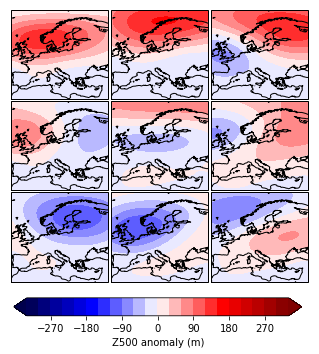

In [19]:
g, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})
g.subplots_adjust(hspace=0.02, wspace=-0.72)
vmin, vmax, step = -330, 330, 30
for i in range(n_rows): 
    for j in range(n_columns):
#         try:
#             ax = axes[i][j]
#             node = 
#         except: #doesn't work when not indexed, when one of n_rows or n_columns = 1
#             if n_rows > n_columns:
#                 ax = axes[i]
#                 node = som_yr.codebook[j]
#             else:
#                 ax = axes[i]
#                 node = som_yr.codebook[i]
        node=som_yr.codebook[i][j]
        node_orig = node.reshape(nr_lat,nr_lon) 
        ax=axes[i][j]
        
        llons, llats = np.meshgrid(file_zg_tot[lon_str], file_zg_tot[lat_str])
        
        ax.coastlines(resolution="50m")
        randomval = int(np.random.random(1)*file_zg_tot[zg_str].shape[0])
        #ax.drawcoastlines()
        im = m.contourf(llons, llats, node_orig, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap="seismic", extend='both', ax=ax)
width, height = 0.4,0.05
cbaxes = g.add_axes([0.31,0.03, width, height])        
cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")
cb.set_label("Z500 anomaly (m)")

g.savefig(f"/rds/general/user/cmt3718/home/notebooks/SOM/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_JJAextd_fin_z.png", bbox_inches="tight", dpi = 300)          
        

## Create SOM infographic

First initialize the SOM with pca and plot this; then select a (random) day in the dataset and show an example of the update of the codebook


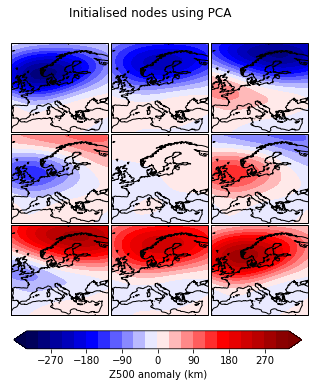

In [349]:
#initialize the SOM
init="pca"
ep = 0
som_yr = somoclu.Somoclu(n_columns, n_rows, maptype="planar",compactsupport=True,initialization=f"{init}", neighborhood=f"{neigh}", std_coeff=std)
som_yr.train(data_yr_reshaped_EUR,epochs=ep,radius0=rad_0,radiusN=rad_N,radiuscooling=f"{rad_cooling}",
         scale0=scale_0,scaleN=scale_N,scalecooling=f"{scale_cooling}")
bmus = som_yr.bmus


g, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})
g.subplots_adjust(hspace=0.02, wspace=-0.72)

cb_factor = 1000

for i in range(n_rows): 
    for j in range(n_columns):
        node=som_yr.codebook[i][j]
        node_orig = node.reshape(nr_lat,nr_lon) 
        ax=axes[i][j]
        
        ax.coastlines(resolution="50m")
        randomval = int(np.random.random(1)*file_zg_tot[zg_str].shape[0])
        im = m.contourf(llons, llats, node_orig/cb_factor, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap="seismic", extend='both', ax=ax)

title = "Initialised nodes using PCA"     
g.suptitle(title)
width, height = 0.4,0.05
cbaxes = g.add_axes([0.31,0.03, width, height])        
cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")
cb.set_label(f"Z500 anomaly (km)")

g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_ep{ep}.png", bbox_inches="tight", dpi = 300)
g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_ep{ep}.pdf", bbox_inches="tight", dpi = 300)

In [328]:
samp_day_reshaped=samp_day.values.reshape(np.prod(samp_day.shape))
codebook_da = xr.DataArray(som_yr.codebook, name = "codebook", dims = ("row", "col", "latlon"))
codebook_da_reshaped = codebook_da.values.reshape(n_rows*n_columns, samp_day_reshaped.shape[0])
codebook_da_reshaped_xr = xr.DataArray(codebook_da_reshaped, name = f"codebook_reshaped")
codebook_da_reshaped_xr = codebook_da_reshaped_xr.rename(dim_0="rowcol").rename(dim_1="latlon_flat")

<xarray.DataArray 'time' ()>
array('1980-05-28T10:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1980-05-28T10:30:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T


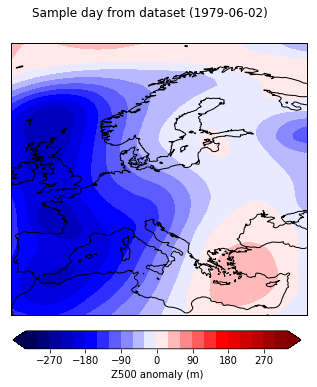

In [331]:
#identify a random day in the dataset

g, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})
g.subplots_adjust(hspace=0.2, wspace=0.2)

ax.coastlines(resolution="50m")
randomval = int(np.random.random(1)*file_zg_tot['z'].shape[0])
randomval = 100

title = "Sample day from dataset (1979-06-02)"     
g.suptitle(title)     
im = m.contourf(llons, llats, file_zg_tot[zg_str][randomval,:,:], np.arange(vmin, vmax+step, step), \
            latlon=True, cmap="seismic", extend='both', ax=ax)
print(file_zg_tot['time'][randomval])    
samp_day = file_zg_tot[zg_str][randomval,:,:]
#g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_psl_sampleday.png", bbox_inches="tight", dpi = 300)
cbaxes = g.add_axes([0.31,0.03, width, height])        
cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")
cb.set_label("Z500 anomaly (m)")        
g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_sampday.png", bbox_inches="tight", dpi = 300)
g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_sampday.pdf", bbox_inches="tight", dpi = 300)        

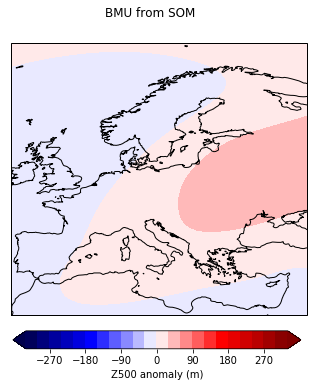

In [332]:
#take the sample day in the codebook and show the update
#first identify which node is the BMU
g, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})
g.subplots_adjust(hspace=0.2, wspace=0.2)

samp_day_reshaped = samp_day.values.reshape(np.prod(samp_day.shape))
rownum, colnum = 3, 3
#for each day define an arbitrarily large euclidean distance
min_euclidean_distance = 1e12
for rowcolnum, codebook in enumerate(codebook_da_reshaped_xr):
    #calculate Euclidean distance between codebook and day in dataset
    euclidean_distance = (np.sum((np.array(samp_day_reshaped)-np.array(codebook.values))**2)**0.5)
    #find optimum minima by redefining the minimum euclidean distance
    if euclidean_distance < min_euclidean_distance:
        #print(f"Redefining optimum for {rowcolnum}")
        min_euclidean_distance = euclidean_distance
        #print(f"min_euclidean_distance = {min_euclidean_distance} for {rowcolnum}")
        min_rowcolnum = rowcolnum  
        
row_BMU, col_BMU = (min_rowcolnum%colnum, min_rowcolnum//(rownum-(rownum-colnum)))        

cb_factor = 1

title = "BMU from SOM"     
g.suptitle(title)     

#plot the BMU
BMU = som_yr.codebook[row_BMU,col_BMU]
BMU_latlon = BMU.reshape(samp_day.shape)


ax.coastlines(resolution="50m")
im = m.contourf(llons, llats, BMU_latlon*cb_factor, np.arange(vmin, vmax+step, step), \
            latlon=True, cmap="seismic", extend='both', ax=ax)

cbaxes = g.add_axes([0.31,0.03, width, height])        
cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")
cb.set_label(f"Z500 anomaly (m)")
g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_BMUsampday2.png", bbox_inches="tight", dpi = 300)
g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_BMUsampday2.pdf", bbox_inches="tight", dpi = 300)   

In [340]:
neigh_fn = np.exp(-float(np.sum((np.array(node)-np.array(BMU))**2))/float((2*(std_coeff*rad_0)**2)))
#radius and learning rate starts at rad_0 and scale0 for the first update and
#finish at rad_N, scaleN with rate of decrease being specified by scalecooling and radiuscooling
#scale0

In [341]:
#then apply the neighbourhood function to update the position for the BMU and its neighbouring nodes
updated_codebook_list = []

for node in codebook_da_reshaped_xr:
    neigh_fn = np.exp(-float(np.sum((node.values-np.array(BMU))**2))/float((2*(std_coeff*rad_0)**2)))
    node_update = node + scale_0*neigh_fn*(samp_day_reshaped - BMU)
    updated_codebook_list.append(node_update)
    
updated_codebook = xr.concat(updated_codebook_list, dim="rowcol")    

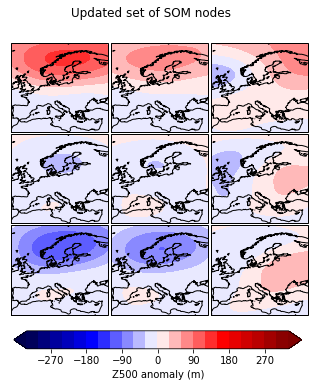

In [342]:
g, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})
g.subplots_adjust(hspace=0.02, wspace=-0.72)

cb_factor = 1

for i in range(n_rows*n_columns):
        node=updated_codebook[i]
        node_orig = node.values.reshape(nr_lat,nr_lon) 
        row = i%3
        col = i//3
        ax=axes[col][row]
        
        ax.coastlines(resolution="50m")
        randomval = int(np.random.random(1)*file_zg_tot[zg_str].shape[0])
        im = m.contourf(llons, llats, node_orig/cb_factor, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap="seismic", extend='both', ax=ax)

title = "Updated set of SOM nodes"     
g.suptitle(title)
width, height = 0.4,0.05
cbaxes = g.add_axes([0.31,0.03, width, height])        
cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")
cb.set_label(f"Z500 anomaly (m)")

g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_updatednodes.png", bbox_inches="tight", dpi = 300)
g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_updatednodes.pdf", bbox_inches="tight", dpi = 300)

(46, 51)

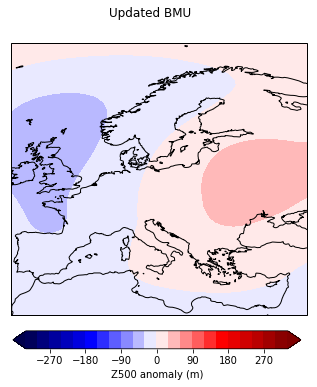

In [347]:
g, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})
g.subplots_adjust(hspace=0.2, wspace=0.2)
g.suptitle("Updated BMU")
ax.coastlines(resolution="50m")
im = m.contourf(llons, llats, updated_codebook[5].values.reshape(llons.shape), np.arange(vmin, vmax+step, step), \
            latlon=True, cmap="seismic", extend='both', ax=ax)

cbaxes = g.add_axes([0.31,0.03, width, height])        
cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")
cb.set_label(f"Z500 anomaly (m)")

g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_updatedBMU2.png", bbox_inches="tight", dpi = 300)
g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_updatedBMU2.pdf", bbox_inches="tight", dpi = 300)

In [146]:
radius0=rad_0
radiusN=rad_N
radiuscooling=f"{rad_cooling}"
scale0=scale_0
scaleN=scale_N
scalecooling=f"{scale_cooling}"
neighborhood=f"{neigh}"
std_coeff=std

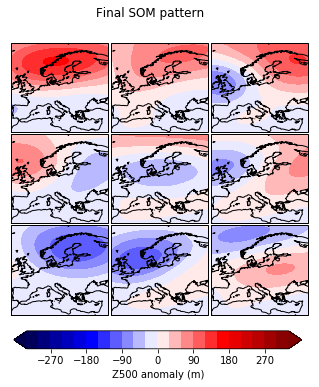

In [264]:
#final the SOM
init="pca"
som_yr = somoclu.Somoclu(n_columns, n_rows, maptype="planar",compactsupport=True,initialization=f"{init}", neighborhood=f"{neigh}", std_coeff=std)
som_yr.train(data_yr_reshaped_EUR,epochs=8,radius0=rad_0,radiusN=rad_N,radiuscooling=f"{rad_cooling}",
         scale0=scale_0,scaleN=scale_N,scalecooling=f"{scale_cooling}")
bmus = som_yr.bmus


g, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(10,5), subplot_kw={'projection': ccrs.PlateCarree()})
g.subplots_adjust(hspace=0.02, wspace=-0.72)

cb_factor = 1

for i in range(n_rows): 
    for j in range(n_columns):
        node=som_yr.codebook[i][j]
        node_orig = node.reshape(nr_lat,nr_lon) 
        ax=axes[i][j]
        
        ax.coastlines(resolution="50m")
        randomval = int(np.random.random(1)*file_zg_tot[zg_str].shape[0])
        im = m.contourf(llons, llats, node_orig/cb_factor, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap="seismic", extend='both', ax=ax)

title = "Final SOM pattern"     
g.suptitle(title)
width, height = 0.4,0.05
cbaxes = g.add_axes([0.31,0.03, width, height])        
cb = g.colorbar(im, cax=cbaxes, orientation="horizontal")
cb.set_label(f"Z500 anomaly (m)")

g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_finalSOM.png", bbox_inches="tight", dpi = 300)
g.savefig(f"/rds/general/user/cmt3718/home/plots/SOM/infographic/SOM_ERA5_{n_rows}x{n_columns}_{domain}_{init}_finalSOM.pdf", bbox_inches="tight", dpi = 300)

In [80]:
#Function to plot the SOM trends
#added values to modify Gerald's function (issues with date formatting)
def saveSOMTrends(som_yr, dates, n_rows, n_columns, savefig_trends, colormap_str, mult_test_method, train_input=False, bmus=None, JJA_days=104, yrst=1979, yrend=2019, samp=50):
    """
    Plots the trends (occurrence, persistence, max duration) of the SOM patterns generated from the GPH data. 
    
    Parameters
    ----------
    som_yr    : somoclu.train.Somoclu
        The trained SOM (somoclu object)
    seas_yr   : xarray.DataArray
        Data array containing GPH data and information on time, latitude, longitude variables in the selected time range, season and region
        
    Returns
    ---------
    grad_list : list 
        List of the gradients of the pattern occurrence trends computed by linear least-squares regression 
    all_occur : list 
        List of occurrences per day in the trained dataset for each SOM pattern
    """
    if train_input==False:
        #calculate the best matching unit
        #Extract pattern data (occurence, persistence, max duration)
        #Store each pattern data as a binary list of len(dates), i.e. [1,0,0,0,1...,1]
        bmus = som_yr.bmus
    
    
    global all_occur #Extra code to store the occurences in a global variable that I can access later
    #print(f"bmus = {bmus}")
    #print(f"bmus.shape = {bmus.shape}")    
    all_occur = [[] for i in range(max(n_rows,n_columns))]
    for a in range(n_rows):
        for b in range(n_columns): 
            curr_occur = []
            for c in bmus:
                if train_input==False:
                    if c.tolist() == [b,a]: #### need to swap the indices here!! #b'a
                        curr_occur.append(1) #This pattern occured on this date
                    else:
                        curr_occur.append(0) #This pattern didn't occur 
                else:
                    if c == [b,a]: #### need to swap the indices here!! #b'a
                        curr_occur.append(1) #This pattern occured on this date
                    else:
                        curr_occur.append(0) #This pattern didn't occur                     
            all_occur[a].append(curr_occur)
    #Loop through each set of circulation occurence data 
    #print(f"dates.values = {dates.values}")
    #print(f"all_occur.shape = {np.array(all_occur).shape}")
    #print(f"dates.shape = {np.array(dates).shape}")
    
    #print(f"styr, endyr = {styr, endyr}")
    da_arr, rownum_arr, colnum_arr = [], [], []
    
    for row in range(n_rows):  
        for col in range(n_columns):
            #print(f"row, col = {row, col}")
            #Need some exception handling for rare cases where any of the patterns doesnt occur in a year
            #NOTE the swapped indices [col][row] here! Doulbe check with Joy's code, see if node number can be confirmed
            #print(f"all_occur[row][col] = {all_occur[row][col]}")
            #print(f"dates = {dates}")
            #all_occur[row][col] is the relevant matrix for investigating case studies
            #print(f"all_occur = {all_occur}")
            cum_data = pd.Series(np.array(all_occur[row][col]), index=dates.values)
            #print(f"cum_data = {cum_data}")
            #to generate the years in the dataset, since cum_data.index.year has issues
            years_num = yrend - yrst
            JJA_days = 104       
            #print(f"cum_data.shape = {cum_data.shape}")
            years_num = int(cum_data.shape[0]/JJA_days)
            #print(f"years_num = {years_num}")
            years_zeros = np.zeros((years_num*JJA_days))
            if type(yrst) == int or type(yrst) == float:
                arr_gen = np.array([years_zeros[JJA_days*i:JJA_days*(i+1)]+i+yrst for i in range(years_num)
                               ]).reshape(years_num*JJA_days)
            else: #yrst an array
                arr_gen = np.array([years_zeros[JJA_days*i:JJA_days*(i+1)]+i+int(yrst.values) for i in range(years_num)
                               ]).reshape(years_num*JJA_days)            

            sort_to_year = cum_data.groupby(arr_gen).apply(list)
            year = sort_to_year.keys().tolist() #[1979, 1980,...]
            occ = [sum(d) for d in sort_to_year]  #[25,40,...]
            # Count streaks 
            streaks = [[sum(1 for i in g) for k,g in groupby(x) if k == 1] for x in sort_to_year]
            streak_count = [[(k, sum(1 for i in g)) for k,g in groupby(sorted(x)) ] for x in streaks]
            
            #Persistence (if statement to avoid division by zero )
            persis = [ sum([x[0]*x[1] for x in year])/sum([x[1] for x in year]) if sum([x[1] for x in year]) != 0 else 0 for year in streak_count ]
            #Max Duration 
            max_dur = [ year[-1][0] if year != [] else 0 for year in streak_count]
            ##want to store occ, persis, max_dur and ev_no in a xarray Dataset/DataArray to save, with the time file showing the years
            ##need to store this for each node (36 different 1d arrays for each model, plus the timestamp)

            def len_iter(items):
                return sum(1 for _ in items)            
            
            def consecutive_one_len(data):
                return len(list(len_iter(run) for val, run in groupby(data) if val))            
            event_no = [consecutive_one_len(d) for d in sort_to_year] 
            
            store = [occ, persis, max_dur, event_no]
            
            da = xarray.DataArray(store, dims = ('SOM_trend_metrics', "year"))
            da['year'] = year
            da['SOM_trend_metrics'] = ['occ', 'persis', 'max_dur', 'event_no']
            da_arr.append(da)
            #store the DataArray and the accompanying row and column number of the SOM pattern            
            rownum_arr.append(row)
            colnum_arr.append(col)
            
    #concatenate the array
    da_xr = xarray.concat(da_arr, dim = ("node"))
    #add a new coordinates to specify the row and column number for each layer
    da_xr = da_xr.assign_coords(
        rownum=('node', rownum_arr))
    da_xr = da_xr.assign_coords(
        colnum=('node', colnum_arr))            
            
    return da_xr, all_occur

In [83]:
data_yr_reshaped_EUR.shape

(4264, 624)

In [85]:
nr_lat, nr_lon = file_zg_tot[lat_str].shape[0], file_zg_tot[lon_str].shape[0]

In [108]:
dates=file_zg_tot['time']

In [109]:
all_occur = [[] for i in range(max(n_rows,n_columns))]
for a in range(n_rows):
    for b in range(n_columns): 
        curr_occur = []
        for c in bmus:
                if c.tolist() == [b,a]: #### need to swap the indices here!! #b'a
                    curr_occur.append(1) #This pattern occured on this date
                else:
                    curr_occur.append(0) #This pattern didn't occur                 
        all_occur[a].append(curr_occur)

In [110]:

da_allocc=xarray.DataArray(all_occur, name = "SOM_data", dims = ("row", "col", "time"))
da_allocc.to_netcdf("~/notebooks/SOM/SOM_data_occ_JJA_extd_era5_z_LTDM_timedtrnd_1979-2019_JJAextd.nc")

In [54]:
da_xr_trend, all_occur = saveSOMTrends(som_yr, dates, n_rows, n_columns, savefig_trends, colormap_str,
                                mult_test_method, train_input=True, bmus=bmus, JJA_days=104, yrst=yrst, yrend=yrend, samp=samp)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Run the cells to train the SOM and extract the trends in the models from the SOMs

In [19]:
tas_file = xarray.open_dataset("/rds/general/project/nowack_graven/live/carl/era5/2m_temperature/2mt_1x1_1979-2019_daymean_LTDM_nolp_anom.nc")['t2m']
tas_file_sel = tas_file.sel(latitude = np.isin(tas_file['latitude'], lats), 
                                  longitude = np.isin(tas_file['longitude'], lons),
                                ).sel(time = np.isin(tas_file['time.season'], season))


data_yr_reshaped.shape = (3772, 575)


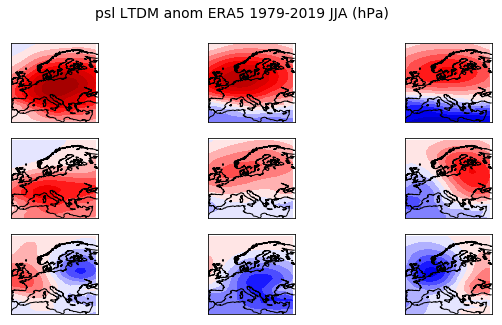

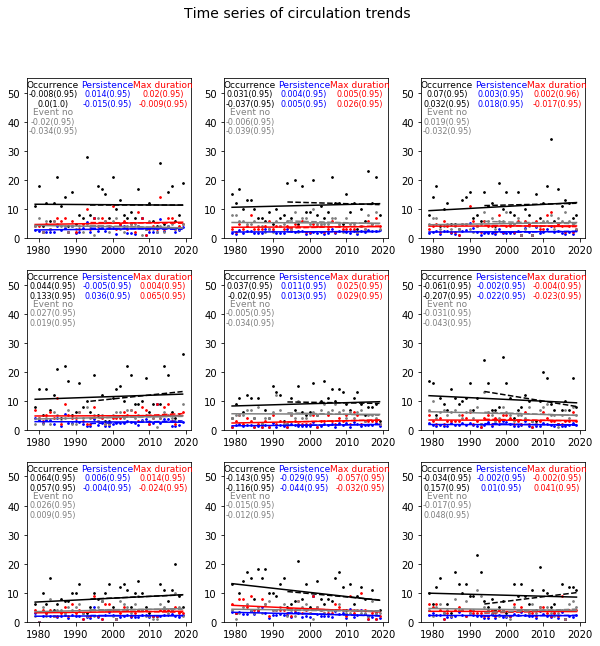

In [37]:
file_zg_str = "/rds/general/project/nowack_graven/live/carl/era5/mean_sea_level_pressure/mslp_ERA5_1979-2019_LTDMdaymean_anom_r180x91.nc"
#file_zg_str = "/rds/general/project/carl_phd/live/carl/data/era5/day/zg/500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas.nc"

#500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas.nc
zg_file = xarray.open_dataset(file_zg_str)

lat_str, lon_str = "lat","lon"#"latitude", "longitude"
zg_str = "msl"#"500zg"

#need to adjust the longitude coordinate if it runs from 0 - 360 instead of -180 to +180
if zg_file[lon_str].max() > 180:
    lon_adjust = 180
    #print(f"zg_file[lon_str].max() > 180: {zg_file[lon_str].max()}")
else:
    lon_adjust = 0
zg_file[lon_str] = zg_file[lon_str]-lon_adjust
lats_arr, lons_arr = [30,76], [-10,40]#[130,222]
grid_res = 2
lats = np.arange(lats_arr[0],lats_arr[1],grid_res) #good for 1x1 data
lons = np.arange(lons_arr[0],lons_arr[1],grid_res)  #good for 1x1 data

season = "JJA"
if lat_str == "latitude":
    file_zg_tot = zg_file.sel(latitude = np.isin(zg_file['latitude'], lats), 
                                  longitude = np.isin(zg_file['longitude'], lons),
                                ).sel(time = np.isin(zg_file['time.season'], season))
else:    
    file_zg_tot = zg_file.sel(lat = np.isin(zg_file["lat"], lats), 
                                  lon = np.isin(zg_file['lon'], lons),
                                ).sel(time = np.isin(zg_file['time.season'], season))

season = "JJA"

vmin, vmax, step = -15,15,1.5
init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling = "pca", "gaussian", 0.5, 50, 1, 0, "linear", 0.1, 0.01, "exponential"
yrst, yrend = 1979, 2019
region, season = "Europe", "JJA"

samp = 15
colormap_str = "seismic"
suptitle="psl LTDM anom ERA5 1979-2019 JJA (hPa)"
#"fdr_bh", "sidak" and "k-FWER"
#all cover different variations on the mltiple hypothesis test applied in Horton et al 2015
mult_test_method = "fdr_bh"#"k-FWER"#"k-FWER"#"none"#"fdr_bh"
g=9.80616
season = "JJA"
#n_rows, n_columns=3,3
domain = "EUR"
savefig_SOM=f"/rdsgpfs/general/user/cmt3718/home/plots/SOM/psl/SOM_ERA5_{n_rows}x{n_columns}_detrended_{domain}_xranom_{zg_str}_LTDM_plots.png"
savefig_trends=f"/rdsgpfs/general/user/cmt3718/home/plots/SOM/psl/SOM_ERA5_{n_rows}x{n_columns}_detrended_circtrends_{domain}_xranom_{zg_str}_LTDM_plots.png"
n_rows, n_columns=3,3
nt_yr, nr_lat, nr_lon = file_zg_tot[zg_str].shape
data_yr_reshaped_eur = file_zg_tot[zg_str].values.reshape(nt_yr, nr_lat*nr_lon)#/g
##freq_list, grad_list_arr, pvals_list_arr, all_occur, som_yr
freq_list_era5_EUR, grad_list_era5_EUR, pvals_list_era5_EUR, SOM_data_era5_EUR, som_yr_era5_EUR = get_SOM_data(file_zg_tot, yrst, yrend, season, region, init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling,
            savefig_SOM, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g, zg_str, colormap_str, suptitle, mult_test_method, #yrst=1979, yrend=2013
                data_yr_reshaped_eur, grid_res, vmin, vmax, step, lat_str, lon_str, JJA_days=92)

#freq_list, grad_list_arr, pvals_list_arr, all_occur, som_yr

#(zg_file, yrst, yrend, season, region, init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling,
#            savefig_title, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g, zg_str, colormap_str, suptitle, mult_test_method, #yrst=1979, yrend=2013
#                data_yr_reshaped, grid_res, vmin, vmax, step, lat_str, lon_str, train_input = False, som_yr = None, JJA_days=92)


#ipython /rds/general/user/cmt3718/home/notebooks/area_thresh-era5.py





Need to plot the frequency list for all the models

In [27]:
pats = np.array(SOM_data_era5_EUR)
hotcold = "hot"

AttributeError: 'DataArray' object has no attribute 'reshape'

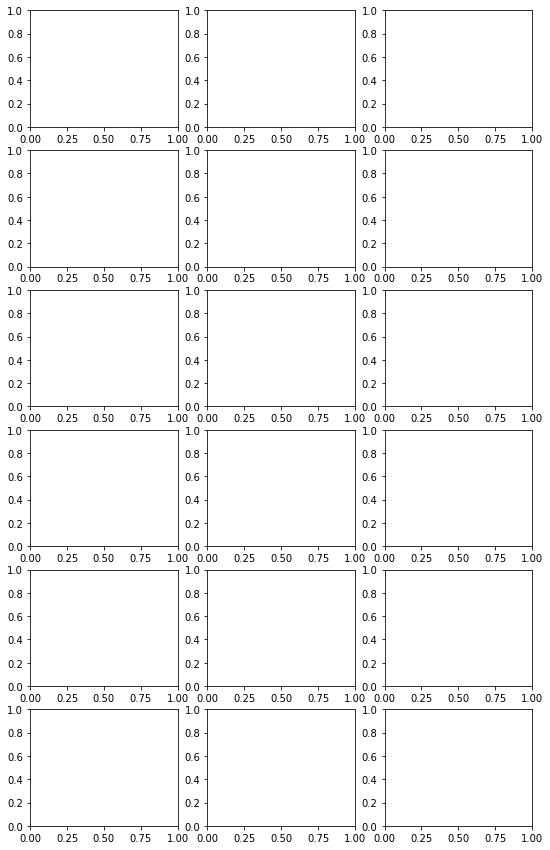

In [46]:
plotEXTTrends(pats, hotcold, yrst, yrend, season, region, file_var = file_zg_tot['msl'], data_europe_yr_temp = tas_file_sel,
                 file_temp = tas_file_sel)

In [45]:
def plotEXTTrends(pats, hotcold, yrst, yrend, season, region, file_var = file_zg_tot, data_europe_yr_temp = tas_file_sel ,
                 file_temp = tas_file_sel ):
    #zg_JJA_eur_dtrnd_tas, tasmax_JJA_eur_dtrnd_zg
    
    """
    Plots the surface temperature extreme trends produced by each SOM pattern and the area-weighted mean of extremes per pattern occurrence
    
    Parameters
    ----------
    pats    : list
        List of occurrences per day in the trained dataset for each SOM pattern, i.e. all_occur from get_SOM_data
    hotcold : str
        Type of temperature extreme to investigate, "hot" or "cold"
    yrst    : int
        Starting/first year of the dataset to pick from
    yrend   : int
        Ending/ last year of the dataset to pick from
    season  : str
        Seasons of the year, {"MAM", "JJA", "SON", "DJF"}
    region  : str
        Region to pick the data from, {"Europe", "WA", "CA", "EA", "ENA"} 
    Returns
    ---------
    mean_occ_list : list
        List of the mean number of temperature extreme occurrences per year per respective SOM pattern occurrence
    trend_list    : list
        List of the gradients of the temperature extreme occurrence per year per SOM pattern occurrence trends computed by linear least-squares regression
    """
    #dates, temp_data, lat_t, lon_t, lats, lons, nt_yr, nr_lat, nr_lon, m = prepDataTemp(yrst, yrend, season, region)

    #psl_JJA_eur_dtrnd_tas, tasmax_JJA_eur_dtrnd_psl
    #zg_JJA_eur_dtrnd_tas, tasmax_JJA_eur_dtrnd_zg
    
    #zg_anom
    #psl_anom
    #tasmax_anom     
    
    #Keep only data within required time range
    lat = file_var['lat']
    lon = file_var['lon']
    
    lat_t = file_temp['latitude']
    lon_t = file_temp['longitude']    
    
#     #Gather and format the SOM input data 
#     if season == "all":
#         seas_yrs = temp_anom_yr
#     else:
#         #Select only dates from the desired season (DJF, MAM, JJA, SON)
#         seas_yrs = temp_anom_yr.sel(time = np.isin(temp_anom_yr['time.season'], season))
#     dates = seas_yrs['time'].data[:]
    
#     #zg_JJA_eur_dtrnd_tas, tasmax_JJA_eur_dtrnd_zg
    
    #anom_reshape = np.transpose(temp_data.reshape(nt_yr,nr_lat*nr_lon))


    #Set up plotting axes
    f, axes = plt.subplots(nrows=2*len(pats),ncols=len(pats[0]), figsize=(9,15))
    f.subplots_adjust(hspace=0.2, wspace=0.2)

    #For now use this global variable to access outside this function ~bad code..
    #may want to code a more comprehensive funct to do both the SOM and temp tgt? 

    #if data is already prepared
    #if (file_var != False):
    lat_europe = file_var['lat']
    lon_europe = file_var['lon']
    lons, lats = np.meshgrid(lon_europe,lat_europe)
    nt_yr = data_europe_yr_temp.shape[0]
    nr_lat = data_europe_yr_temp.shape[1]
    nr_lon = data_europe_yr_temp.shape[2]
    dates = file_var['time'].data[:]  
    data_yr_reshaped=data_europe_yr_temp.values.reshape((nt_yr,nr_lat*nr_lon))
        
        
    data_yr_reshaped_tr = np.transpose(data_yr_reshaped)
   
    if hotcold == "hot":
        grid_ext = np.percentile(data_yr_reshaped_tr,95, axis=1)
    elif hotcold == "cold":
        grid_ext = np.percentile(data_yr_reshaped_tr,5, axis=1)        
        
        
    
    global pat_occ_list
    global ext_occ_list

    pat_occ_list = []
    ext_occ_list = []
    trend_list = []
    mean_occ_list = []
    
    for p in range(len(pats)):
        for q in range(len(pats[0])):
            ax = axes[p][q]
            ax1 = axes[p+2][q]

            #Keep only anomaly data that occurs on days where the pattern occurs. Note index swap here too
            trend = data_europe_yr_temp.reshape(nt_yr,nr_lat*nr_lon) * np.transpose(np.array([pats[q][p],]*nr_lat*nr_lon))

            #Values that qualify as hot/ cold extremes = 1, 0 otherwise
            if hotcold == "hot":
                trend[trend < np.array([grid_ext]*nt_yr)] = 0
            elif hotcold == "cold":
                trend[trend > np.array([grid_ext]*nt_yr)] = 0
            trend[trend != 0] = 1
            trend = trend.reshape(nt_yr, nr_lat, nr_lon)

            #Store the number of pattern (pats[q][p]) occurences per year in a list 
            cum_data = pd.Series(pats[q][p], index=dates)
            sort_to_year = cum_data.groupby(cum_data.index.year).apply(list) 
            year = sort_to_year.keys().tolist() #[1979, 1980,...]
            occ = [sum(d) for d in sort_to_year]

            #Create datarray to associate the extreme occurences with their corresponding dates
            ext = xarray.DataArray(trend, coords=[dates, lat_t, lon_t], dims=['time', 'lat', 'lon'])
            ext_yr = ext.groupby('time.year').sum('time').data
            #Reshape and tranpose array, then perform linear regression on the yearly data per grid cell
            ext_trs = np.transpose(ext_yr.reshape(yrend+1-yrst,nr_lat*nr_lon))
            result = [scipy.stats.linregress(year,y)[0] for y in ext_trs]
            result = np.array(result).reshape(nr_lat,nr_lon)


            lons_t, lats_t = np.meshgrid(lon_t,lat_t)

            #if hotcold == "hot":
            #    clrmap = LinearSegmentedColormap.from_list(cmap_name, colour, N=14)
            #elif hotcold == "cold":
           #     clrmap = LinearSegmentedColormap.from_list(cmap_name, colour[::-1], N=14) #Reverse the colourmap
            
            
            #plot_temp_field(m, result, lats_t, lons_t, -0.35, 0.35, ax=ax, grid=True, cmap=clrmap)
            

            #Now compute the mean of extremes per pattern occurence 
            a = ext_yr.reshape(yrend+1-yrst,nr_lat*nr_lon)
            b = np.transpose(np.array([occ]*nr_lat*nr_lon))
            ext_perpat = np.divide(a, b, out=np.zeros_like(a), where=b!=0) #For handling division by 0 occurrences

            #ext_perpat = ext_yr.reshape(yrend+1-yrst,nr_lat*nr_lon) / np.transpose(np.array([occ]*nr_lat*nr_lon)) #Divison by zero happens here

            #Proper area/ cosine of latitude weighing 
            weights = np.cos(lat_t*np.pi/180.0)
            area_weighted_ext = ext_perpat.reshape(yrend+1-yrst,nr_lat,nr_lon)*np.array(np.transpose([weights]*nr_lon))/sum(weights)
            area_ext = np.mean(area_weighted_ext, axis = 2) #Get the mean value of the same latitude grid cells. 
            #Sum through all latitudes of grid cells to get the area-weighted mean 
            weighted_ext = np.sum(area_ext, axis = 1)

            #Global var stuff
            pat_occ_list.append(occ)
            ext_occ_list.append(weighted_ext)

            print ("Mean T05/95 per pat occ: ", str(round(np.mean(weighted_ext),3))) 
            mean_occ_list.append(np.mean(weighted_ext))
            def fit(m,x,c):  #simple linear function
                return m*x + c

            m0, c0, r0, p0, err0 = scipy.stats.linregress(year,weighted_ext)
            m1, c1, r1, p1, err1 = scipy.stats.linregress(year[11:],weighted_ext[11:])  #1990-2013
            trend_list.append(m0)
            fit_rs = [fit(m0,x,c0) for x in year]
            fit_rs1 = [fit(m1,x,c1) for x in year[11:]]

            #Plot results
            ax1.scatter(year, weighted_ext, c='k', s=3)
            ax1.plot(year, fit_rs, c='k')
            ax1.plot(year[11:], fit_rs1, '--', c='k')
            ax1.set_ylim((0,0.3))
            


            ax1.text(0.05, 0.97, str(round(m0,4))+"("+str(round(p0,2))+")", transform=ax1.transAxes, fontsize=11, verticalalignment='top')
            ax1.text(0.05, 0.91, str(round(m1,4))+"("+str(round(p1,2))+")", transform=ax1.transAxes, fontsize=11, verticalalignment='top')
    f.suptitle(f'Summer hot extreme trends in Europe ({yrst}-{yrend})', fontsize=14)
    return mean_occ_list, trend_list

In [ ]:
mean_pat_occ = np.array(freqs)#*0.92 here, but unclear why
mean_pat_occ

In [ ]:
pat_occ_trend = np.array(gradients)
pat_occ_trend

In [ ]:
mean_T95_occ = np.array(mean_occ_list) 
mean_T95_occ

In [ ]:
T95_trend = np.array(trend_list)
T95_trend

In [ ]:
dyn = pat_occ_trend*mean_T95_occ
therm = T95_trend*mean_pat_occ

The interaction term is defined as the trend in the product of circulation pattern occurences and intensity of temperature deviations.  <br>
- Write some new code to do this calculation. I will need to extract the pattern and temperature extreme occurences per year data from the 2 main functions ``get_SOM_data`` and ``plotEXTTrends``.  

In [ ]:
#Test function
P = np.array([[1,2,3],[4,5,6]])
P - np.transpose([np.mean(P,axis=1)]*3)

#pat_occ_list and ext_occ_list are global variables from the plotTrend function
#pattern occurrence deviations from mean 
pat_occ_list = np.array(pat_occ_list)
pat_dev = pat_occ_list - np.transpose([np.mean(pat_occ_list,axis=1)]*pat_occ_list.shape[1])

#extreme occurrence deviations from mean
ext_occ_list = np.array(ext_occ_list)
ext_dev = ext_occ_list - np.transpose([np.mean(ext_occ_list,axis=1)]*ext_occ_list.shape[1])

#Product of deviations
prod_dev = pat_dev*ext_dev

Now compute the trends in the products of deviations to obtain the interaction term. 


In [ ]:
interact = []
for n in range(len(prod_dev)):
    m, c, r, p, err = scipy.stats.linregress(year,prod_dev[n])
    mI, cI, rI, pI, errI = scipy.stats.linregress(year[11:],prod_dev[n][11:])  #1990-2013 Ice Era

    interact.append(m)


In [ ]:
total = dyn+therm+interact
da = {'Pat occ trend': pat_occ_trend, 'Mean pat occ': mean_pat_occ, 'T95 per pat occ trend': T95_trend, \
    'Mean T95 per pat occ': mean_T95_occ, 'Dyn Trend': np.around(dyn,2), 'Thermo trend': np.around(therm,2),  
     'Inter trend': np.around(interact,2), 'Total trend': np.around(total,2)}
df1 = pd.DataFrame(data=da)

In [ ]:
#Columns 10 -13
per_trend = total/sum(total)
per_dyn = dyn/total
per_therm = therm/total
per_inter= interact/total

In [ ]:
d2 = {'Percent of trend': np.around(per_trend*100,1), 'Percent dynamic': np.around(per_dyn*100,1), \
      'Percent thermo': np.around(per_therm*100,1), 'Percent inter': np.around(per_inter*100,1)}
df2 = pd.DataFrame(data=d2)
pd.concat([df1, df2], axis=1)

data_yr_reshaped.shape = (42136, 600)


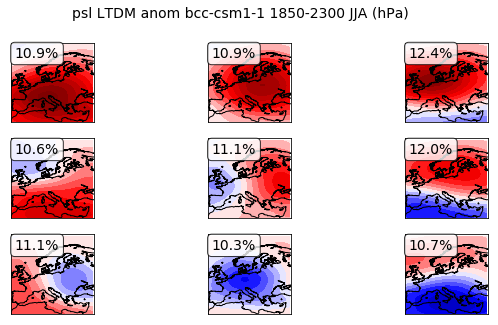

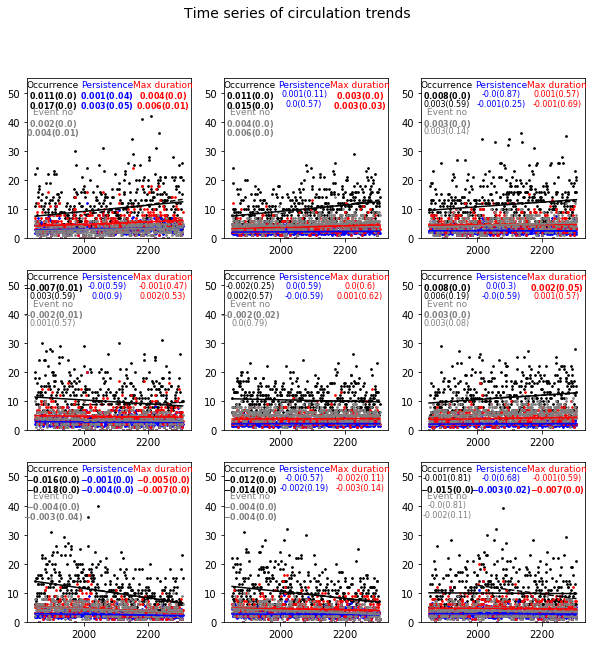

In [12]:
file_zg_str = '/rds/general/user/cmt3718/ephemeral/cmip5/bcc-csm1-1/rcp85/day/r1i1p1/psl/psl_day_bcc-csm1-1_ssp585_r1i1p1_18500101-23001231_r180x91mt_LTDM_anom.nc'
#"/rds/general/project/nowack_graven/live/carl/era5/mean_sea_level_pressure/mslp_ERA5_1979-2019_LTDMdaymean_anom_r180x91.nc"

#500zg_JJA_era5_1979-2019_daymean_EurAR5_1x1_anom_dtrnd_wrt_tas.nc
zg_file = xarray.open_dataset(file_zg_str)

lat_str, lon_str = "lat", "lon"
mdl = "bcc-csm1-1"
#need to adjust the longitude coordinate if it runs from 0 - 360 instead of -180 to +180
if zg_file[lon_str].max() > 180:
    lon_adjust = 180
    #print(f"zg_file[lon_str].max() > 180: {zg_file[lon_str].max()}")
else:
    lon_adjust = 0
zg_file[lon_str] = zg_file[lon_str]-lon_adjust
lats_arr, lons_arr = [30,78], [-10,40]#[130,222]
grid_res = 2
lats = np.arange(lats_arr[0],lats_arr[1],grid_res) #good for 1x1 data
lons = np.arange(lons_arr[0],lons_arr[1],grid_res)  #good for 1x1 data

season = "JJA"
if lat_str == "latitude":
    file_zg_tot = zg_file.sel(latitude = np.isin(zg_file['latitude'], lats), 
                                  longitude = np.isin(zg_file['longitude'], lons),
                                ).sel(time = np.isin(zg_file['time.season'], season))
else:    
    file_zg_tot = zg_file.sel(lat = np.isin(zg_file["lat"], lats), 
                                  lon = np.isin(zg_file['lon'], lons),
                                ).sel(time = np.isin(zg_file['time.season'], season))

vmin, vmax, step = -15,15,1.5
init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling = "pca", "gaussian", 0.5, 50, 1, 0, "linear", 0.1, 0.01, "exponential"
yrst, yrend = 1979, 2019
region, season = "Europe", "JJA"
zg_str = "psl"
samp = 150
colormap_str = "seismic"
yrst, yrend = int(file_zg_tot['time.year'].min()), int(file_zg_tot['time.year'].max())
suptitle=f"psl LTDM anom {mdl} {yrst}-{yrend} JJA (hPa)"
#"fdr_bh", "sidak" and "k-FWER"
#all cover different variations on the mltiple hypothesis test applied in Horton et al 2015
mult_test_method = "fdr_bh"#"k-FWER"#"k-FWER"#"none"#"fdr_bh"
g=9.80616
#n_rows, n_columns=3,3
domain = "EUR"
savefig_SOM=f"/rdsgpfs/general/user/cmt3718/home/plots/SOM/psl/SOM_{mdl}_{n_rows}x{n_columns}_detrended_{domain}_xranom_{zg_str}_LTDM.png"
savefig_trends=f"/rdsgpfs/general/user/cmt3718/home/plots/SOM/psl/SOM_{mdl}_{n_rows}x{n_columns}_detrended_circtrends_{domain}_xranom_{zg_str}_LTDM.png"
n_rows, n_columns=3,3
nt_yr, nr_lat, nr_lon = file_zg_tot[zg_str].shape
data_yr_reshaped_eur = file_zg_tot[zg_str].values.reshape(nt_yr, nr_lat*nr_lon)#/g

freq_list, grad_list, pvals_list, SOM_data, som_yr = get_SOM_data(file_zg_tot, yrst, yrend, season, region, init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling,
            savefig_SOM, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g, zg_str, colormap_str, suptitle, mult_test_method, #yrst=1979, yrend=2013
                data_yr_reshaped_eur, grid_res, vmin, vmax, step, lat_str, lon_str, JJA_days=92)

#freq_list, grad_list_arr, pvals_list_arr, all_occur, som_yr

#(zg_file, yrst, yrend, season, region, init, neigh, std, ep, rad_0, rad_N, rad_cooling, scale_0, scale_N, scale_cooling,
#            savefig_title, savefig_trends, n_rows, n_columns, lats_arr, lons_arr, samp, g, zg_str, colormap_str, suptitle, mult_test_method, #yrst=1979, yrend=2013
#                data_yr_reshaped, grid_res, vmin, vmax, step, lat_str, lon_str, train_input = False, som_yr = None, JJA_days=92)


#ipython /rds/general/user/cmt3718/home/notebooks/area_thresh-era5.py



